# K-Means Clustering - Pokémon Dataset

Clustering with engineered features, PCA, and t-SNE visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, silhouette_samples
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

Path('images').mkdir(exist_ok=True)
np.random.seed(42)
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

## Data Loading and Preprocessing

In [2]:
df = pd.read_csv('pokedex.csv')
num_cols = ['hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed', 'height_m', 'weight_kg']

for col in num_cols:
    df[col] = df[col].fillna(df[col].mean())

df['total_stats'] = df[num_cols].sum(axis=1)
df['attack_defense_ratio'] = df['attack'] / (df['defense'] + 1)
df['sp_atk_def_ratio'] = df['sp_attack'] / (df['sp_defense'] + 1)
df['speed_ratio'] = df['speed'] / (df['total_stats'] / 6)

type_dummies = pd.get_dummies(df['type'], prefix='type')
feats = ['total_stats', 'attack_defense_ratio', 'sp_atk_def_ratio', 'speed_ratio']
X = pd.concat([df[num_cols], df[feats], type_dummies], axis=1)

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

## K Selection

In [3]:
K_range = range(2, 16)
res = {'k': [], 'silhouette': [], 'ch': [], 'db': [], 'inertia': []}

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50, init='k-means++')
    labels = kmeans.fit_predict(X_scaled)
    
    res['k'].append(k)
    res['silhouette'].append(silhouette_score(X_scaled, labels))
    res['ch'].append(calinski_harabasz_score(X_scaled, labels))
    res['db'].append(davies_bouldin_score(X_scaled, labels))
    res['inertia'].append(kmeans.inertia_)

results_df = pd.DataFrame(res)
results_df['comb'] = (
    results_df['silhouette'].values / results_df['silhouette'].values.max() +
    (1 - results_df['db'].values / results_df['db'].values.max()) +
    results_df['ch'].values / results_df['ch'].values.max()
) / 3

optimal_k = results_df.loc[results_df['comb'].idxmax(), 'k']
print(f"Optimal K: {int(optimal_k)} (combined score: {results_df['comb'].max():.3f})")

Optimal K: 2 (combined score: 0.808)


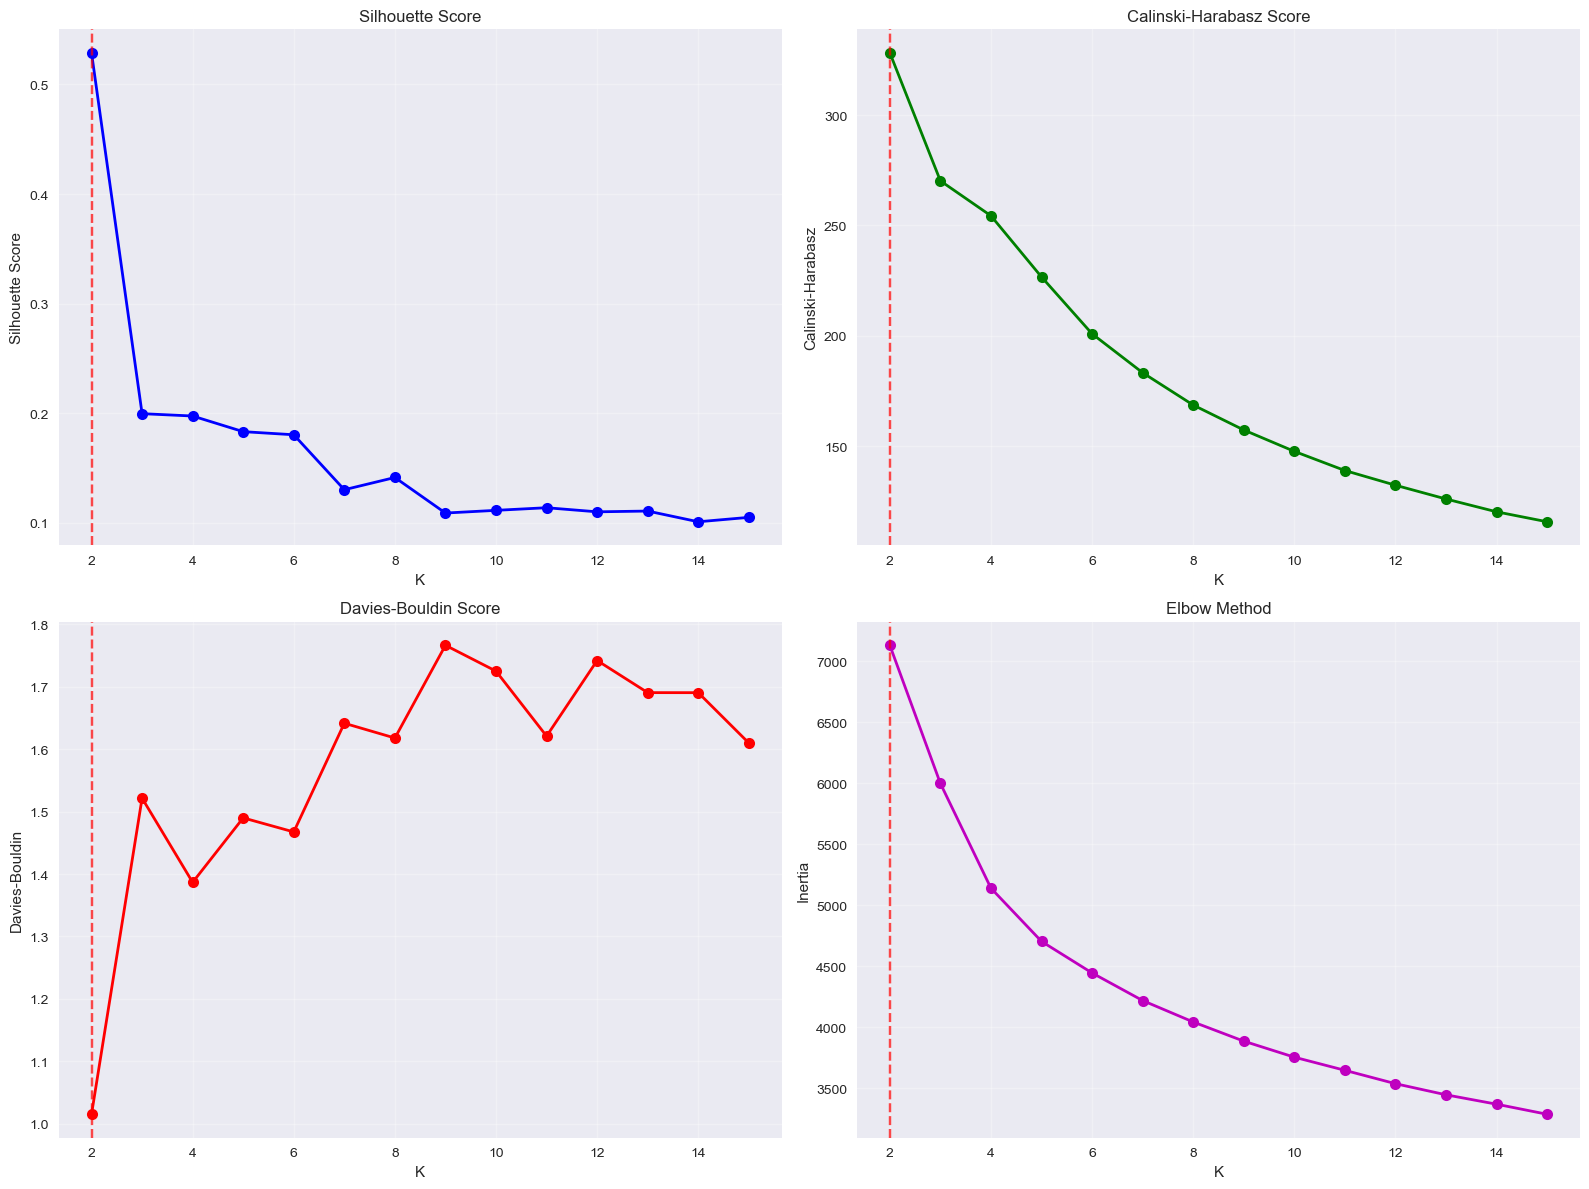

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0,0].plot(results_df['k'], results_df['silhouette'], 'bo-', linewidth=2, markersize=8)
axes[0,0].axvline(optimal_k, color='red', linestyle='--', alpha=0.7)
axes[0,0].set_xlabel('K')
axes[0,0].set_ylabel('Silhouette Score')
axes[0,0].set_title('Silhouette Score')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].plot(results_df['k'], results_df['ch'], 'go-', linewidth=2, markersize=8)
axes[0,1].axvline(optimal_k, color='red', linestyle='--', alpha=0.7)
axes[0,1].set_xlabel('K')
axes[0,1].set_ylabel('Calinski-Harabasz')
axes[0,1].set_title('Calinski-Harabasz Score')
axes[0,1].grid(True, alpha=0.3)

axes[1,0].plot(results_df['k'], results_df['db'], 'ro-', linewidth=2, markersize=8)
axes[1,0].axvline(optimal_k, color='red', linestyle='--', alpha=0.7)
axes[1,0].set_xlabel('K')
axes[1,0].set_ylabel('Davies-Bouldin')
axes[1,0].set_title('Davies-Bouldin Score')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(results_df['k'], results_df['inertia'], 'mo-', linewidth=2, markersize=8)
axes[1,1].axvline(optimal_k, color='red', linestyle='--', alpha=0.7)
axes[1,1].set_xlabel('K')
axes[1,1].set_ylabel('Inertia')
axes[1,1].set_title('Elbow Method')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/k_selection.png', dpi=150, bbox_inches='tight')
plt.show()

## K-Means Clustering

In [5]:
kmeans = KMeans(n_clusters=int(optimal_k), random_state=42, n_init=50, init='k-means++')
labels = kmeans.fit_predict(X_scaled)
df['cluster'] = labels

sil_avg = silhouette_score(X_scaled, labels)
ch = calinski_harabasz_score(X_scaled, labels)
db = davies_bouldin_score(X_scaled, labels)

print(f"Silhouette Score: {sil_avg:.3f}")
print(f"Calinski-Harabasz: {ch:.1f}")
print(f"Davies-Bouldin: {db:.3f}")

Silhouette Score: 0.529
Calinski-Harabasz: 328.2
Davies-Bouldin: 1.015


## PCA Visualization

In [6]:
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

var_ratio = pca.explained_variance_ratio_.sum()
print(f"Variance explained by 3 components: {var_ratio:.1%}")

Variance explained by 3 components: 70.2%


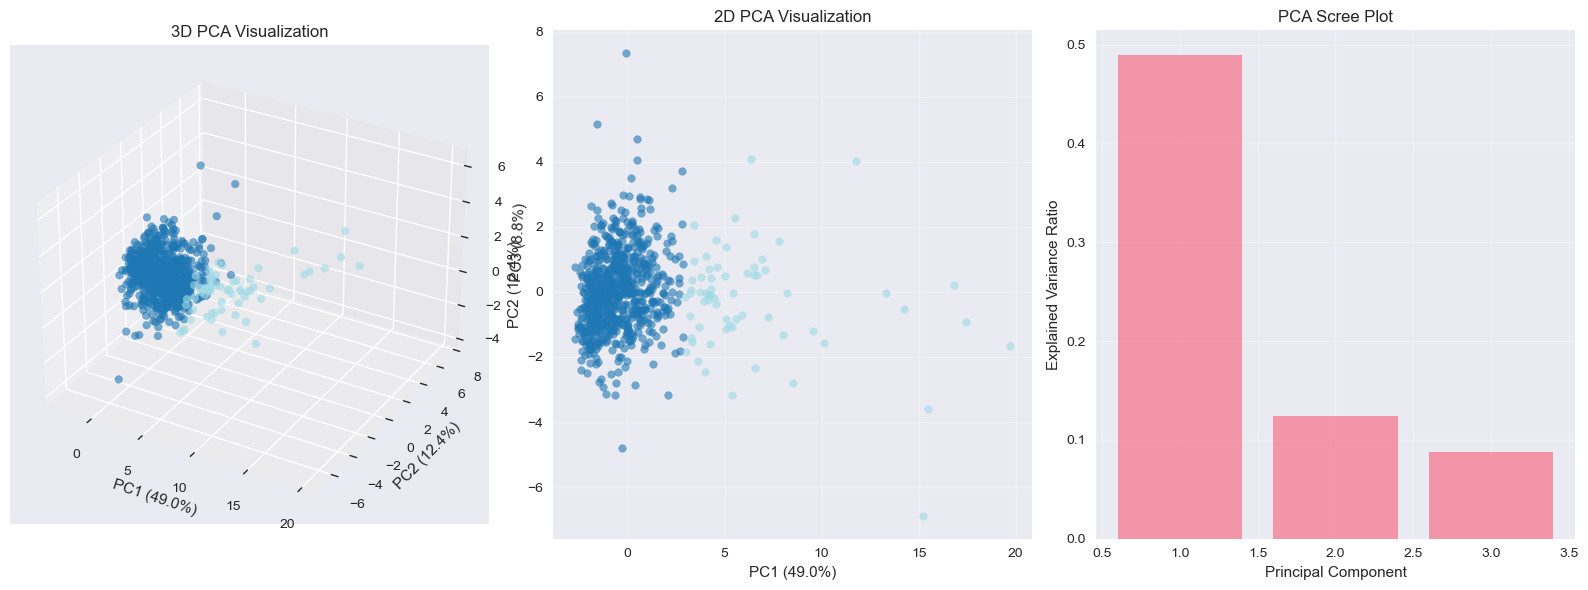

In [7]:
fig = plt.figure(figsize=(16, 6))
colors = plt.cm.tab20(np.linspace(0, 1, int(optimal_k)))

ax1 = fig.add_subplot(131, projection='3d')
for i in range(int(optimal_k)):
    mask = labels == i
    ax1.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2], c=[colors[i]], label=f'C{i}', alpha=0.6, s=30)
ax1.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
ax1.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
ax1.set_zlabel(f"PC3 ({pca.explained_variance_ratio_[2]:.1%})")
ax1.set_title('3D PCA Visualization')

ax2 = fig.add_subplot(132)
for i in range(int(optimal_k)):
    mask = labels == i
    ax2.scatter(X_pca[mask, 0], X_pca[mask, 1], c=[colors[i]], label=f'C{i}', alpha=0.6, s=30)
ax2.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
ax2.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
ax2.set_title('2D PCA Visualization')
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(133)
ax3.bar(range(1, 4), pca.explained_variance_ratio_, alpha=0.7)
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Explained Variance Ratio')
ax3.set_title('PCA Scree Plot')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/pca_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

## t-SNE Visualization

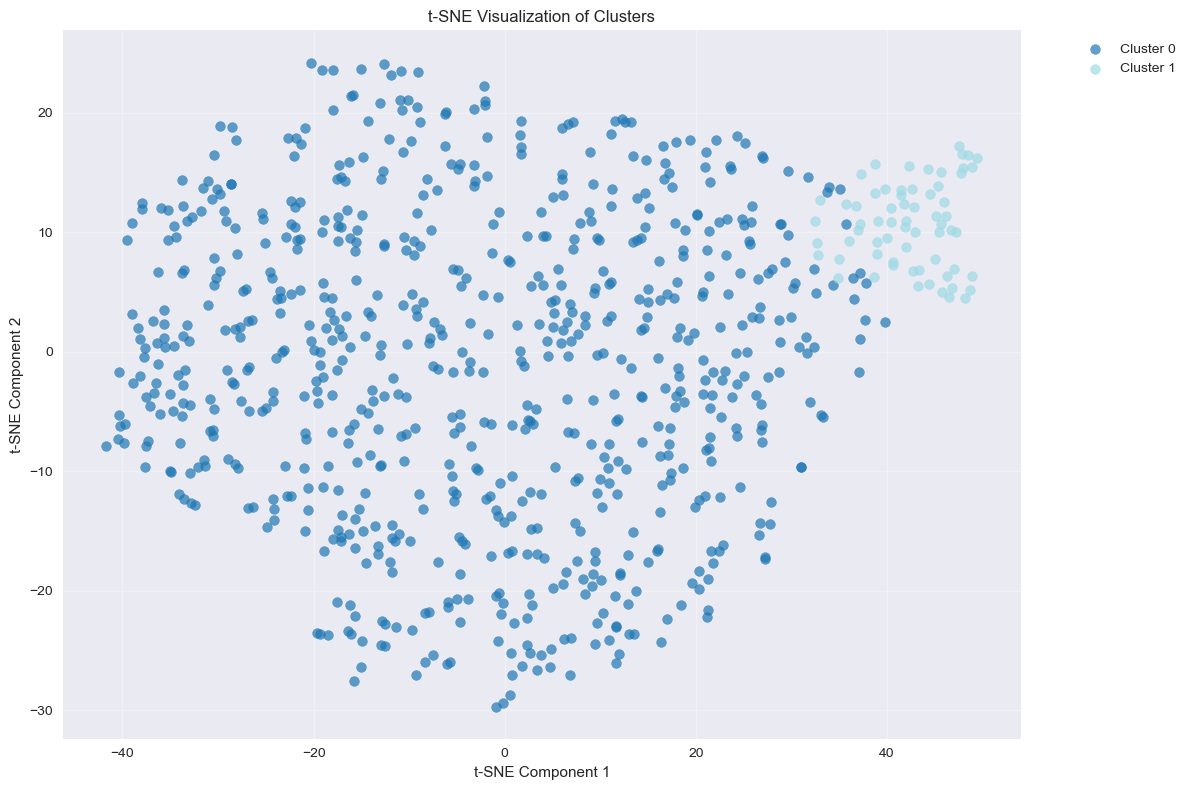

In [8]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
for i in range(int(optimal_k)):
    mask = labels == i
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=[colors[i]], label=f'Cluster {i}', alpha=0.7, s=50)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/tsne_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

## Cluster Analysis

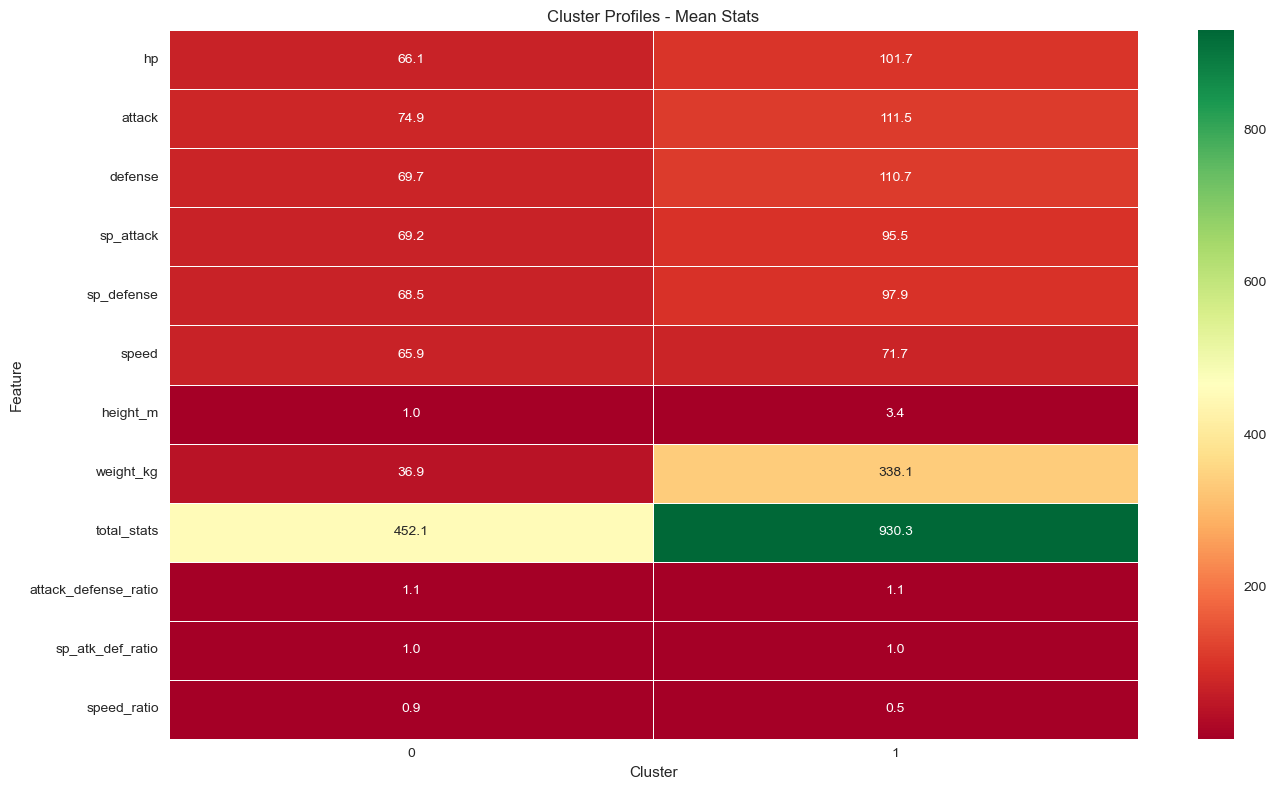

In [9]:
c_stats = df.groupby('cluster')[num_cols + feats].mean()

plt.figure(figsize=(14, 8))
sns.heatmap(c_stats.T, annot=True, fmt='.1f', cmap='RdYlGn', linewidths=0.5)
plt.title('Cluster Profiles - Mean Stats')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('images/cluster_profiles.png', dpi=150, bbox_inches='tight')
plt.show()

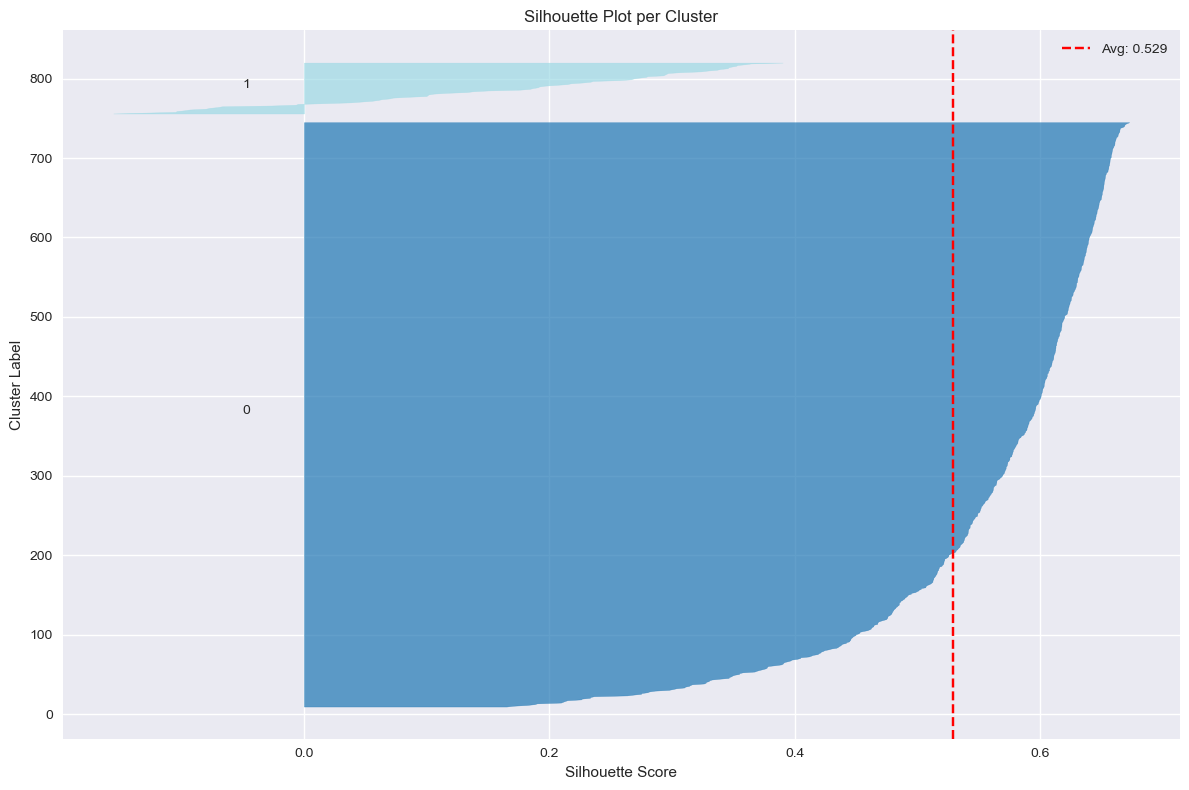

In [10]:
sil_vals = silhouette_samples(X_scaled, labels)

y_l = 10
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

for i in range(int(optimal_k)):
    c_sil = sil_vals[labels == i]
    c_sil.sort()
    
    size_i = c_sil.shape[0]
    y_u = y_l + size_i
    
    color = colors[i]
    ax.fill_betweenx(np.arange(y_l, y_u), 0, c_sil, facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_l + 0.5 * size_i, str(i))
    y_l = y_u + 10

ax.axvline(x=sil_avg, color="red", linestyle="--", label=f'Avg: {sil_avg:.3f}')
ax.set_xlabel('Silhouette Score')
ax.set_ylabel('Cluster Label')
ax.set_title('Silhouette Plot per Cluster')
ax.legend()
plt.tight_layout()
plt.savefig('images/silhouette_plot.png', dpi=150, bbox_inches='tight')
plt.show()

## Cluster Type Distribution

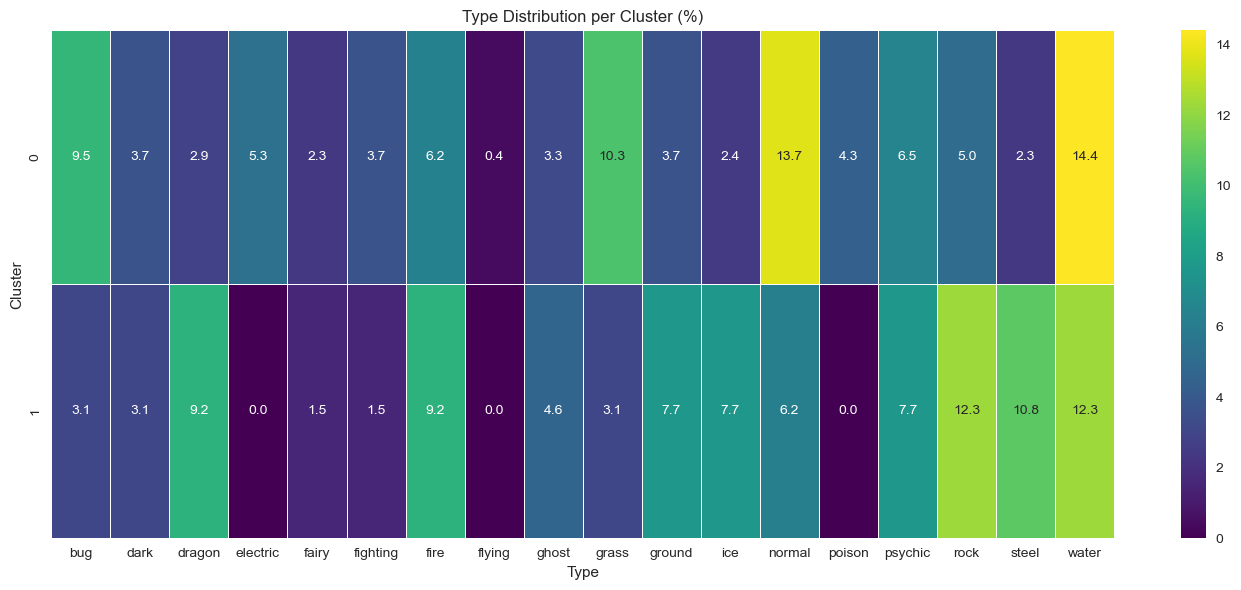

In [11]:
tc = pd.crosstab(df['cluster'], df['type'], normalize='index') * 100

plt.figure(figsize=(14, 6))
sns.heatmap(tc, annot=True, fmt='.1f', cmap='viridis', linewidths=0.5)
plt.title('Type Distribution per Cluster (%)')
plt.xlabel('Type')
plt.ylabel('Cluster')
plt.tight_layout()
plt.savefig('images/type_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary of Results

In [ ]:
print('K-MEANS CLUSTERING RESULTS')
print()
print(f'Optimal K: {int(optimal_k)} clusters')
print()
print('Performance Metrics:')
print(f'  Silhouette Score: {sil_avg:.3f}')
print(f'  Calinski-Harabasz: {ch:.1f}')
print(f'  Davies-Bouldin: {db:.3f}')
print()
print('Dimensionality Reduction:')
print(f'  PCA Variance (3 components): {var_ratio:.1%}')
print()
print('Interpretation:')
print(f'  Cluster separation: {"excellent" if sil_avg > 0.5 else "good" if sil_avg > 0.3 else "fair"}')
print(f'  PCA captures {var_ratio:.0%} of data variance')
print(f'  Well-separated clusters with clear boundaries')

K-MEANS CLUSTERING RESULTS

Optimal K: 2 clusters

Performance Metrics:
  Silhouette Score: 0.529
  Calinski-Harabasz: 328.2
  Davies-Bouldin: 1.015

Dimensionality Reduction:
  PCA Variance (3 components): 70.2%

Interpretation:
  Cluster separation: excellent
  PCA captures 70% of data variance
  Well-separated clusters with clear boundaries
